In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn import metrics

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.base import cloned

In [2]:
ttype_qual_labels = pd.read_csv("./NotebookInputs/inh_ivscc_shiny_ttype_and_quality.csv",index_col=0)
metatdata_csv = pd.read_csv("./NotebookInputs/20200711_patchseq_metadata_mouse.csv")

no_metadata = [s for s in ttype_qual_labels.index if s not in metatdata_csv.cell_specimen_id.values]
print("The following cells are in shiny but not the manuscript's metadata file:")
print(no_metadata)

merged_labels = ttype_qual_labels.merge(metatdata_csv,left_on='spec_id_label',right_on='cell_specimen_id')
print(merged_labels.shape)

merged_labels_core_i3 = merged_labels[merged_labels['Tree_call_label']!='PoorQ']
#if this fails there is a disagreement between metadata csv ttype and shiny ttype
assert merged_labels_core_i3[merged_labels_core_i3['T-type Label'] != merged_labels_core_i3['Tree_first_cl_label']].empty
print("{} Poor Q Cells dropped".format(len(merged_labels[merged_labels['Tree_call_label']=='PoorQ'])))

The following cells are in shiny but not the manuscript's metadata file:
[761816186, 966835644]
(517, 25)
14 Poor Q Cells dropped


In [3]:
merged_labels_core_i3 = merged_labels[merged_labels['Tree_call_label']!='PoorQ']
#if this fails there is a disagreement between metadata csv ttype and shiny ttype
assert merged_labels_core_i3[merged_labels_core_i3['T-type Label'] != merged_labels_core_i3['Tree_first_cl_label']].empty
print("{} Poor Q Cells dropped".format(len(merged_labels[merged_labels['Tree_call_label']=='PoorQ'])))

14 Poor Q Cells dropped


In [4]:
relevant_cols = ['cell_specimen_id','T-type Label',"MET-type Label","Tree_call_label"]
relevant_labels = merged_labels_core_i3[relevant_cols]
relevant_labels["subclass"] = relevant_labels['T-type Label'].str.split(" ").str.get(0)
relevant_labels["subclass"] = relevant_labels["subclass"].replace("Serpinf1","Vip")

/var/folders/kx/xq42kw197c5_qw6kxgnr4nkr0000gq/T/ipykernel_94165/2827553882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_labels["subclass"] = relevant_labels['T-type Label'].str.split(" ").str.get(0)
/var/folders/kx/xq42kw197c5_qw6kxgnr4nkr0000gq/T/ipykernel_94165/2827553882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_labels["subclass"] = relevant_labels["subclass"].replace("Serpinf1","Vip")


In [5]:
ivscc_features = pd.read_csv("./NotebookInputs/inh_ivscc_RawFeatureWide.csv",index_col=0)
all_feature_columns = ivscc_features.columns.to_list()
flags = ['rad','diam','area']

droppers = [c for c in all_feature_columns if any([i in c for i in flags])]
print("Dropping:")
for  i in droppers:
    print(i)
all_feature_columns = [c for c in all_feature_columns if c not in droppers]


merged_features = relevant_labels.merge(ivscc_features,right_on='specimen_id',left_on='cell_specimen_id')
labels_to_predict = ['T-type Label',"MET-type Label","subclass"]

merged_features[['cell_specimen_id']+labels_to_predict].to_csv("./CellsUsedInIVSCCClassifiers.csv")
merged_features = merged_features.sample(frac=1)

Dropping:
basal_dendrite_mean_diameter
basal_dendrite_total_surface_area
soma_surface_area


In [6]:
merged_features.shape

(503, 51)

In [7]:
all_feature_columns

['axon_bias_x',
 'axon_bias_y',
 'axon_depth_pc_0',
 'axon_depth_pc_1',
 'axon_depth_pc_2',
 'axon_depth_pc_3',
 'axon_depth_pc_4',
 'axon_emd_with_basal_dendrite',
 'axon_exit_distance',
 'axon_exit_theta',
 'axon_extent_x',
 'axon_extent_y',
 'axon_frac_above_basal_dendrite',
 'axon_frac_below_basal_dendrite',
 'axon_frac_intersect_basal_dendrite',
 'axon_max_branch_order',
 'axon_max_euclidean_distance',
 'axon_max_path_distance',
 'axon_mean_contraction',
 'axon_num_branches',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_total_length',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_calculate_number_of_stems',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_frac_above_axon',
 'basal_dendrite_frac_below_axon',
 'basal_dendrite_frac_intersect_axon',
 'basal_dendrite_max_branch_order',
 'basal_dendrite_max_euclidean_distance',
 'basal_dendrite_max_path_distance',
 'basal_dendrite_mean_contraction',
 'basal_dendrite_num_bran

In [8]:
label_column = 'MET-type Label'
X_df = merged_features.copy()

label_count_dict = X_df[label_column].value_counts().to_dict()
below_cutoff = [k for k,v in label_count_dict.items() if int(v) < 5]

X_df = X_df[~X_df[label_column].isin(below_cutoff)]
X_df = X_df[~X_df[label_column].isnull()]


# Feature selection 
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_df[all_feature_columns], X_df[label_column])

feature_importances = clf.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=all_feature_columns).sort_values(ascending=False)

selected_features_importance = feature_importance_series.index.tolist()[:-10]  
dropped_features = feature_importance_series.index.tolist()[-10:]
feature_cols = selected_features_importance

X_df = X_df[[c for c in X_df.columns if c not in dropped_features]]

feat_means = X_df[feature_cols].mean()
feat_std = X_df[feature_cols].std()
# feature_cols = feature_columns
X_df[feature_cols] = (X_df[feature_cols]-X_df[feature_cols].mean())/X_df[feature_cols].std()


X = X_df[feature_cols].values
y = X_df[label_column].values
X_train, X_test, y_train, y_test = train_test_split(X_df[['cell_specimen_id']+feature_cols], 
                                                    y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                   shuffle=True)

training_ids = X_train['cell_specimen_id'].values
testing_ids = X_test['cell_specimen_id'].values

X_train = X_train[feature_cols].values
X_test = X_test[feature_cols].values

assert len(np.unique(y_train)) == len(np.unique(y_test))

In [9]:
# pd.DataFrame(selected_features_importance, columns=['features_included_after_feature_selection']).to_csv("FeatureSelectionWithoutRadius.csv")


In [10]:
# select_with_rad = pd.read_csv("FeatureSelectionWithRadius.csv")
# select_without_rad = pd.read_csv("FeatureSelectionWithoutRadius.csv")
# set(select_with_rad['features_included_after_feature_selection'].values) - set(select_without_rad['features_included_after_feature_selection'].values)

In [11]:

# set(select_without_rad['features_included_after_feature_selection'].values) - set(select_with_rad['features_included_after_feature_selection'].values)

In [12]:

#logisitic regression
logreg_penalty = ["l1","l2","elasticnet",None]
logreg_C = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.025, 0.05, 0.1, 0.25, 1, 5,10]
logreg_intercept_scaling = [1,1.5,2,3,]
logreg_class_weight = ['balanced']
logreg_l1_ratio = [0.25,0.5,0.75]

logreg_grid = {
    "penalty":logreg_penalty,
    "C":logreg_C,
    "intercept_scaling":logreg_intercept_scaling,
    "class_weight":logreg_class_weight,
    "l1_ratio":logreg_l1_ratio
}


#SVM
svm_c = [0.00005, 0.0001, 0.0005,0.001, 0.0025, 0.005 , 0.0075, 0.01, 0.015, 0.025, 0.05, 0.1, 0.25, 1, 5,10]
svm_kernel_params = ["linear", "rbf", 'poly','sigmoid'] 
svm_poly_degree = [3,4,5,6]
svm_gamma = ["scale", "auto"]
svm_class_weight = ['balanced']
probability = [True]
svm_grid = {
    "C":svm_c,
    "kernel":svm_kernel_params,
    "degree":svm_poly_degree,
    "gamma":svm_gamma,
    "class_weight":svm_class_weight,
    "probability":probability,
}

#Random Forest
rfc_n_estimators = [5,10,15,25,40,50,75,150,250] 
rfc_max_features = ['sqrt', None]
rfc_max_depth = [2,3,5,10,20,35,50,100,None]
rfc_min_samples_split = [5,10,20,25]
rfc_min_samples_leaf = [5, 10,15,25]
rfc_bootstrap = [True]
rfc_class_weight= ['balanced']

rfc_random_grid = {
    'n_estimators': rfc_n_estimators,
    'max_features': rfc_max_features,
    'max_depth': rfc_max_depth,
    'min_samples_split': rfc_min_samples_split,
    'min_samples_leaf': rfc_min_samples_leaf,
    'bootstrap': rfc_bootstrap,
    'class_weight':rfc_class_weight,
}





meta_config_dict = {
        
    "LogisticRegression": {
        "sklearn_classifier":LogisticRegression(),
        "parameter_grid":logreg_grid,
    },
        
     "SupportVector": {
        "sklearn_classifier":SVC(),
        "parameter_grid":svm_grid,
    },
    
    "RandomForest": {    
        "sklearn_classifier":RandomForestClassifier(),
        "parameter_grid":rfc_random_grid,
    },
}

In [13]:
meta_gs_records = {}
for iii in range(3):
    print(f"\n\n\n\nMETA ITERATION {iii}\n\n\n\n\n")

    
    
    # pop this in so test set is different in the three outer iterations
    label_column = 'MET-type Label'
    X_df = merged_features.copy()

    label_count_dict = X_df[label_column].value_counts().to_dict()
    below_cutoff = [k for k,v in label_count_dict.items() if int(v) < 5]

    X_df = X_df[~X_df[label_column].isin(below_cutoff)]
    X_df = X_df[~X_df[label_column].isnull()]

    
    # Feature selection 
#     clf = RandomForestClassifier(n_estimators=100)
#     clf.fit(X_df[all_feature_columns], X_df[label_column])

#     feature_importances = clf.feature_importances_
#     feature_importance_series = pd.Series(feature_importances, index=all_feature_columns).sort_values(ascending=False)

#     selected_features_importance = feature_importance_series.index.tolist()[:-10]  
#     dropped_features = feature_importance_series.index.tolist()[-10:]
#     feature_cols = selected_features_importance
#     X_df = X_df[[c for c in X_df.columns if c not in dropped_features]]

    feat_means = X_df[all_feature_columns].mean()
    feat_std = X_df[all_feature_columns].std()
    # feature_cols = feature_columns
    X_df[all_feature_columns] = (X_df[all_feature_columns]-X_df[all_feature_columns].mean())/X_df[all_feature_columns].std()


    X = X_df[all_feature_columns].values
    y = X_df[label_column].values
    X_train, X_test, y_train, y_test = train_test_split(X_df[['cell_specimen_id']+all_feature_columns], 
                                                        y,
                                                        stratify=y, 
                                                        test_size=0.2,
#                                                         random_state=42,
                                                       shuffle=True)

    training_ids = X_train['cell_specimen_id'].values
    testing_ids = X_test['cell_specimen_id'].values

    X_train = X_train[all_feature_columns].values
    X_test = X_test[all_feature_columns].values

    assert len(np.unique(y_train)) == len(np.unique(y_test))

    # pop this in so test set is different in the three outer iterations   
    
    
    
    gs_records = {}
    for name, config_dict in meta_config_dict.items():   
        print(name)
        print()
        grid_params = config_dict['parameter_grid']
        this_estimator = config_dict['sklearn_classifier']
        this_gs = RandomizedSearchCV(estimator = this_estimator, 
                           param_distributions = grid_params, 
                           n_iter = 500, 
                           cv = 5, 
                           verbose=2,
                           random_state=42, 
                          return_train_score=True,
                           n_jobs = -1)

        this_gs.fit(X_train,y_train)

        gs_records[name]=this_gs


        best_idx = this_gs.best_index_

        best_test_score_mean = this_gs.cv_results_['mean_test_score'][best_idx]
        best_test_score_std = this_gs.cv_results_['std_test_score'][best_idx]

        best_train_score_mean = this_gs.cv_results_['mean_train_score'][best_idx]
        best_train_score_std = this_gs.cv_results_['std_train_score'][best_idx]

        best_clf_validation_acc = this_gs.best_estimator_.score(X_test, y_test)

        print("Best Classifier CV Results:\n")
        print("Train Acc: {}+/-{}".format(best_train_score_mean,best_train_score_std))
        print("Test Acc: {}+/-{}".format(best_test_score_mean,best_test_score_std))
        print("Hold-Out Validation Acc: {}".format(best_clf_validation_acc))
        print('\n\n')

        gs_df = pd.DataFrame(this_gs.cv_results_)

        gs_df = gs_df[~gs_df['mean_test_score'].isnull()]
        gs_df = gs_df.sort_values(by='mean_test_score')
        plt.plot(range(len(gs_df)), gs_df['mean_train_score'],label='train')
        plt.plot(range(len(gs_df)),gs_df['mean_test_score'],label='test')
        plt.axhline(best_clf_validation_acc,c='green',label='Best Clf Hold-Out Validation')
        plt.title(name)
        plt.ylabel("Accuracy")
        plt.legend()
        plt.xlabel("GridSearch Epoch")
        plt.show()
        plt.clf()
        print('"Best" classifier parameters:')
        print(print(this_gs.best_estimator_))
        print("\n\n")
        
    meta_gs_records[iii] = gs_records





META ITERATION 0





LogisticRegression

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015, total=   0.0s
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015, total=   0.0s[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015, total=   0.0s

[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015, total=   0.0s
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015, total=   0.0s
[CV] 

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/

[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005, total=   0.0s
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005, total=   0.0s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005 
[CV] penalty=l1, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=10, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=10 
[CV]  penalty=l1, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=l1, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=l1, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=l1, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=l1, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=10, total=   0.0s

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1918, in __call

[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5 
[CV]  penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5 
[CV]  penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5 
[CV]  penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_sca

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
T

[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.25, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.25 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.01, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_s

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/

[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.001 
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.001 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.001 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.001 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=l1, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.25 
[CV]  penalty=l1, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=l1, 

tic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is

[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.1, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.1 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.0125, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.0125 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=0.1 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=1, total=   0.1s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=1 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.005, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.005 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=1, total=   0.

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
T

[CV]  penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5 
[CV]  penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5 
[CV]  penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5 
[CV]  penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5 
[CV]  penalty=None, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=5, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.001 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, 

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/

[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.025, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.025 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.001 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=10, total=   0.1s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=10 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1.5, class_weight=balanced, C=10, total=   0.1s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1.5, class_weight=balanced, C=10 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.025, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.025 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.001, t

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/sst_py38/

[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=10, total=   0.1s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=10 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.001 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=10, total=   0.1s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=10 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=5, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=5 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=10, total=   0.1s
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=0.0125 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=0.0

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda

[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.001, total=   0.0s
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.015, total=   0.0s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV] penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01 
[CV]  penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01, total=   0.0s
[CV] penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01 
[CV]  penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01, total=   0.0s
[CV] penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01 
[CV]  penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01, total=   0.0s
[CV] penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.01 
[CV]  penalty=None, l1_ratio=0.5, intercept_scaling=1, class_weight=

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
T

[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.25, total=   0.1s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=5 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.001 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005 
[CV]  penalty=elasticnet, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005 
[CV]  penalty=elasticnet, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.005 
[CV]  penalty=elasticnet, l1_ratio=0.25, in

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/sst_py38/

pt_scaling=1.5, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.01 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=1, total=   0.1s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=0.001, total=   0.0s
[

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/sst_py38/

[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.005, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.005 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.05, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.05 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=5, total=   0.1s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=5 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=1, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=1 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1.5, class_weight=balanced, C=1, total=   0.1s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=1.5, class_weight=balanced, C=1 
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.005, total=   0.0s


/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/l

[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.1, total=   0.1s
[CV] penalty=l1, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=1 
[CV]  penalty=l1, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=1, total=   0.0s
[CV] penalty=l1, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=1 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=1, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=1 
[CV]  penalty=l1, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=1, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=3, class_weight=balanced, C=0.015 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.05, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.0125 
[CV]  penalty=elasticnet, l1_ratio=0.5, intercept_scaling=1, class_weight=balanced, C=0.0

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/l

[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.025, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05 
[CV]  penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05, total=   0.0s
[CV] penalty=None, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.05 
[CV]  penalty=None, l1_ratio=0.25, intercept_s

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The score on this t


[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=0.015, total=   0.0s
[CV] penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=0.015 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.005, total=   0.0s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=3, class_weight=balanced, C=0.005 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.25, total=   0.1s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=0.25 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.025, total=   0.1s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.025 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=5, total=   0.2s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=5 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1, class_weight=balanced, C=1, 

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1918, in __call

[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.015, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.015 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1, class_weight=balanced, C=5 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.25, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.25 
[CV]  penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.015, total=   0.0s
[CV] penalty=l2, l1_ratio=0.75, intercept_scaling=1.5, class_weight=balanced, C=0.015 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.25, total=   0.1s
[CV] penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=0.025 
[CV]  penalty=elasticnet, l1_ratio=0.25, intercept_scaling=1.5

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/joblib/parallel.py", line 1918, in __call

[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=5, total=   0.1s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=5 
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=2, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=elasticnet

/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/sst_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
T

[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=5, total=   0.1s
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=2, class_weight=balanced, C=0.25, total=   0.1s
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=5, total=   0.1s
[CV]  penalty=l2, l1_ratio=0.5, intercept_scaling=2, class_weight=balanced, C=5, total=   0.1s
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10 
[CV]  penalty=l2, l1_ratio=0.25, intercept_scaling=1.5, class_weight=balanced, C=10, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.25 
[CV]  penalty=elasticnet, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.25, total=   0.0s
[CV] penalty=elasticnet, l1_ratio=0.75, intercept_scaling=3, class_weight=balanced, C=0.25 
[CV]  penalty=elasticnet, l1_ratio=0.75,

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

In [ ]:
meta_records = {
    
    "Logistic-Regression":{
        "Train Acc":[0.9002545297670406,  0.9645599654874892, 0.9678429680759274],
        "Cross-Validation Acc": [0.5932672590567327, 0.5823308270676691, 0.5719753930280247],
        "Hold-Out Acc":[0.625, 0.57291666666666, 0.5833333333333334]
    },
    
     "Support-Vector":{
        "Train Acc":[0.9206039689387403, 0.8969715271786022, 0.9934404659188957 ],
        "Cross-Validation Acc": [0.5773752563226248, 0.5667805878332193,  0.5904306220095694],
        "Hold-Out Acc":[0.6458333333333334, 0.5729166666666666, 0.6041666666666666]
    },
    
     "RandomForest":{
        "Train Acc":[0.9271678170836928, 0.9337338222605694, 0.9442234685073337, ],
        "Cross-Validation Acc": [0.6010936431989065, 0.5930622009569377, 0.5773752563226248],
        "Hold-Out Acc":[0.5625, 0.6041666666666666, 0.59375]
    }
}


In [ ]:
from matplotlib import cm
cm.cmap

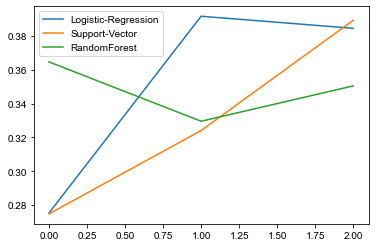

In [ ]:
fig,axe=plt.gcf(),plt.gca()
for method, method_dict in meta_records.items():
    variance = np.array(method_dict['Train Acc'])-np.array(method_dict['Hold-Out Acc'])
    axe.plot(variance,label=method)
axe.legend()    

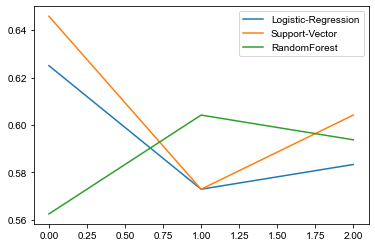

In [ ]:
fig,axe=plt.gcf(), plt.gca()
for method, method_dict in meta_records.items():
    
#     variance = np.array(method_dict['Train Acc'])-np.array(method_dict['Hold-Out Acc'])
#     axe.plot(variance,label=method)
    axe.plot(method_dict['Hold-Out Acc'],label=method)
axe.legend()    

In [ ]:
# CHOOSING THE RFC THAT HAD THE HIGHEST TEST ACC

chosen_random_forest_gs = meta_gs_records[1]['RandomForest']

best_parameters = chosen_random_forest_gs.best_params_
print(best_parameters)

{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}


In [ ]:
best_parameters ={'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
chosen_random_forest_gs.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Now that we have identified optimal model params for the pseq classifier,we will generate a confusion Matrix for Chosen RFC

In [8]:
best_classifier = RandomForestClassifier(**best_parameters)

pseq_data_df = merged_features.copy()
keep_mets = [k for k,v in pseq_data_df['MET-type Label'].value_counts().to_dict().items() if v>=5]
pseq_data_df = pseq_data_df[pseq_data_df['MET-type Label'].isin(keep_mets)]

In [9]:
training_samples_by_met_type = pseq_data_df['MET-type Label'].value_counts().to_dict()

-----------------------------------------------------------------
RFC by MET-type Label
-----------------------------------------------------------------

There are 22 unique labels in the 477 cells

Sst-MET-12     55
Lamp5-MET-1    43
Pvalb-MET-4    41
Sncg-MET-1     32
Pvalb-MET-2    32
Sst-MET-3      26
Sst-MET-13     23
Vip-MET-1      23
Vip-MET-5      21
Sst-MET-2      18
Sst-MET-6      18
Sst-MET-8      18
Vip-MET-4      17
Sst-MET-1      16
Vip-MET-2      15
Sst-MET-4      15
Sst-MET-9      14
Sst-MET-5      12
Sst-MET-7      11
Pvalb-MET-3    10
Sst-MET-10     10
Pvalb-MET-1     7
Name: MET-type Label, dtype: int64

soma_aligned_dist_from_pia


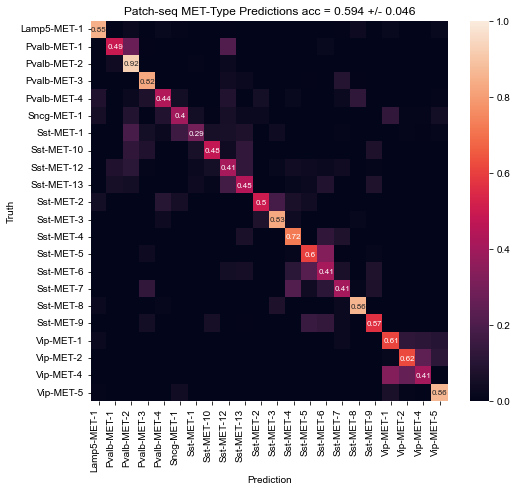

In [12]:
pseq_rfc_fig, pseq_rfc_axe, pseq_scores, pseq_cmat, pseq_raw_cmat =  clf_stratified(df=pseq_data_df,
                                                                                   ft_cols=all_feature_columns,
                                                                                   labels_col='MET-type Label',
                                                                                   title='Patch-seq MET-Type Predictions', 
                                                                                   clf_obj=best_classifier, 
                                                                                   undersample_dict = {}, 
                                                                                   num_folds=5,
                                                                                   num_outter_its=20)


In [16]:
pseq_rfc_fig.savefig("Final_Patch_Seq_RFC_Conf_Matrix.png",dpi=400,bbox_inches='tight')

In [14]:
pseq_raw_cmat.to_csv("Final_Patch_Seq_RFC_Conf_Matrix.csv")

In [17]:
pseq_cmat.to_csv("Final_Patch_Seq_RFC_Conf_Matrix_RowNorm.csv")

# Use the above classifier to predict labels for EM data

In [85]:
em_feature_df = pd.read_csv("./NotebookInputs/inh_em_RawFeatureWide.csv")
best_classifier = RandomForestClassifier(**best_parameters)


In [91]:
em_met_result_df, em_results, em_all_accuracies = predict_labels_with_probability(source_dataframe=pseq_data_df,
                                                                                prediction_dataframe=em_feature_df,
                                                                                prediction_id_column='specimen_id',
                                                                                feature_columns=all_feature_columns,
                                                                                label_column="MET-type Label",
                                                                                clf_obj = best_classifier,
                                                                                min_class_size = 5,
                                                                                min_class_size_subsampling=5,
                                                                                feature_weights=None,
                                                                                num_iterations=500,
                                                                                subsampling_rate=0.95,
                                                                                undersample_dict={},
                                                                               )

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [06:14<00:00,  1.33it/s]


In [92]:
em_met_result_df.to_csv("Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius.csv")

In [94]:
em_met_result_df.probability.describe()

count    173.000000
mean       0.891191
std        0.157836
min        0.358000
25%        0.824000
50%        0.984000
75%        1.000000
max        1.000000
Name: probability, dtype: float64

In [109]:
em_met_result_df["num_pseq_training_samples"] = em_met_result_df['predicted_MET-type Label'].map(training_samples_by_met_type)

In [102]:
previous_predictions = pd.read_csv("../big_batch_v1_correct_layer_template/EM_MC_Predicted_MET_Labels_11_18_22.csv")
previous_predictions.columns=[c+"_previous" for c in previous_predictions.columns]

compare_df = previous_predictions.merge(em_met_result_df,left_on='id_previous',right_on='id')
compare_df[compare_df['predicted_MET-type Label_previous']!=compare_df['predicted_MET-type Label']]

,Unnamed: 0_previous,id_previous,predicted_MET-type Label_previous,probability_previous,id,predicted_MET-type Label,probability
1,2,864691135118298333,Sst-MET-6,0.598,864691135118298333,Sst-MET-4,0.79


In [3]:
from sklearn.metrics import confusion_matrix
from copy import copy
def clf_stratified(df, ft_cols,labels_col,title, clf_obj, undersample_dict = {}, num_folds=5,num_outter_its=1):
    """
    Will run  labels_col prediction  with stratified kfold to properly include all ttypes in each train/test split
    
    num folds should  equal 5 if we are doing an n>=5 threshold
    undersample_dict = dicitonary where keys are met-labels and values are the fraction of datapoints to drop
    from that group
    clf_obj should be an unfit classifier object
    
    """
    df = copy(df)
#     shape_0=len(df)
#     df.dropna(inplace=True)
#     shape_1=len(df)
    
#     if shape_1 != shape_0:
#         print("Dropped {} Nan Containing Cells".format(shape_0-shape_1))
        
    n_ct_series = df.groupby(labels_col)[labels_col].transform('size').astype(str)
    n_ct_series = ' (n=' + n_ct_series + ')'
#     df[labels_col] = df[labels_col] + n_ct_series.astype(str)
    

    feature_values = df[ft_cols].values
    labels = df[labels_col].values

    min_num_groupsize = min(df[labels_col].value_counts().to_dict().values())
    if min_num_groupsize < 5:
        num_folds = min_num_groupsize
        
    if num_folds < 2:
        num_folds = 2
    print('-----------------------------------------------------------------')
    print('RFC by {}'.format(labels_col))
    print('-----------------------------------------------------------------'+'\n')

    print('There are {} unique labels in the {} cells'.format(len(df[labels_col].unique()),len(labels)))
    print('')
    print(df[labels_col].value_counts())
    print('')

    score = np.zeros(len(ft_cols))
    avg_score = []

    possible_labels = df[labels_col].unique()
    num_correct = dict(zip(possible_labels,np.zeros(len(possible_labels))))
    num_occurances = dict(zip(possible_labels,np.zeros(len(possible_labels))))
    value_counts_dict = dict(zip(df[labels_col].unique(),df[labels_col].value_counts()))
    conf_mat = np.zeros([len(np.unique(labels)),len(np.unique(labels))])

    for it in range(num_outter_its):# range(0,100//num_folds):
        
        #shuffle data, train and test
        skfold = StratifiedKFold(n_splits=num_folds, random_state=None, shuffle=True)

        feature_values = df[ft_cols].values
        labels = df[labels_col].values
        
        if undersample_dict != {}:
            
            train_df = pd.DataFrame(np.hstack((feature_values, labels.reshape(-1,1))),columns=ft_cols+[labels_col])
            for k,pct_to_erod in undersample_dict.items():
                n_drop_from_training = int( len(train_df[train_df['met_type']==k])*pct_to_erod)
                tr_drop_index = np.random.choice(train_df[train_df['met_type']==k].index, n_drop_from_training, replace=False, )
                train_df = train_df.loc[~train_df.index.isin(tr_drop_index)]

            feature_values = train_df[feature_columns].values
            labels = train_df['met_type'].values
            
            print(train_df['met_type'].value_counts())
        
        for train_index, test_index in skfold.split(feature_values, labels):
            X_train = feature_values[train_index]
            Y_train = labels[train_index]

            X_test = feature_values[test_index]
            Y_test = labels[test_index]
            
            
            clf = clone(clf_obj)

                
            clf.fit(X_train, Y_train)

            results = clf.predict(X_test)

            # getting per class accuracy scores
            for ind,res in enumerate(results):
                num_occurances[Y_test[ind]]+=1
                if res == Y_test[ind]:
                    num_correct[res]+=1           

            conf_mat+=confusion_matrix(Y_test,results,labels = possible_labels)

            mean_score = clf.score(X_test,Y_test)
            avg_score.append(mean_score)
#             score+=clf.feature_importances_


    Average_performance = np.mean(np.asarray(avg_score))
    Std_performance = np.std(np.asarray(avg_score))
    score_dict = dict(zip(score,ft_cols))
    sorted_scores_dict = {}
    for enum,i in enumerate(sorted(score_dict,reverse=True)):
        sorted_scores_dict[i] = score_dict[i]
        print(score_dict[i])
    
    for ke in value_counts_dict.keys():
        class_acc = num_correct[ke]/num_occurances[ke]

    fig = plt.gcf()
    ax = plt.gca()
    row_sums = np.sum(conf_mat,axis=1)
    raw_confusion_df = pd.DataFrame(conf_mat,columns=possible_labels,index=possible_labels)
    percent_conf_mat = (conf_mat.T / row_sums).T
    np.nan_to_num(percent_conf_mat,0)

    
    
    use_custom_sort = False
    
    if use_custom_sort:
        subclass_order = ["IT","PT","NP","CT","L6b"]
        sorted_labels = sorted(possible_labels, key=lambda x: (subclass_order.index(x.split("-")[0]),x.split("-")[-1]))
    else:
        sorted_labels = sorted(possible_labels)
    
    confusion_df = pd.DataFrame(percent_conf_mat,columns=possible_labels)
    confusion_df.set_index([possible_labels],inplace=True)
    confusion_df = confusion_df[sorted_labels]
    
    if use_custom_sort:
        new_confusion_df = pd.DataFrame()
        for lab in sorted_labels:
            this_lab = confusion_df.loc[lab]
            new_confusion_df= new_confusion_df.append(this_lab)
        confusion_df = new_confusion_df[sorted_labels]
        
    else:
        confusion_df.sort_index(inplace=True) 

    vals = confusion_df.values
    vals = vals.astype(object)
    for i in range(len(vals)):
        for j in range(len(vals)):
            if i==j:
                vals[i,j] = str(round(vals[i,j],2))
                continue
            else:
                vals[i,j] = ''
    diagonal_vals = vals.astype('str')

    con = sns.heatmap(confusion_df,
                      annot=diagonal_vals,
                      fmt = '', 
                      xticklabels=sorted_labels,
                      yticklabels= sorted_labels,
                     vmin=0,vmax=1.0,
                      annot_kws={"size":8})

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,horizontalalignment='right')

    con.set_xlabel('Prediction')
    con.set_ylabel('Truth')

    fig.set_size_inches(8,7)
    confusion_title = title + ' acc = {} +/- {}'.format(round(Average_performance,3),round(Std_performance,3))
    ax.set_title(confusion_title)
    return fig,ax, sorted_scores_dict, confusion_df, raw_confusion_df


In [90]:
from tqdm import tqdm
from sklearn.base import clone


def predict_labels_with_probability(source_dataframe,
                                    prediction_dataframe,
                                    prediction_id_column,
                                    feature_columns,
                                    label_column,
                                    clf_obj,
                                    min_class_size = 5,
                                    min_class_size_subsampling=5,
                                    feature_weights=None,
                                    num_iterations=500,
                                    subsampling_rate=0.95,
                                    undersample_dict={},
                                   ):
    
    """

    :param source_dataframe: dataframe, the training dataframe (IVSCC) must have all feature columns and label_column (e.g. met_type)
    :param prediction_dataframe: dataframe, the dataframe you would like to assign labels to, must have all feature columns and an id column
    :param prediction_id_column: str, specimen id column in the prediction dataframe
    :param feature_columns: list of features, must be present in both dataframes
    :param label_column: str, what column from the source_dataframe  you want to predict 
    :param min_class_size: int, the smallest representation allowed in training data, instances from a class with fewer than this value will be dropped
    :param min_class_size_subsampling: int, when subsampling, what is the smallest you want to erode any given class of training data
    :param feature_weights: list/array of feature weights if you want to scale them for any distance based metrics
    :param num_iterations: int, how many iterations of classification to run
    :param subsampling_rate: float in range 0-1.0. Represents the percent of IVSCC cells to subsample in each iteration


    :return: result_df: dataframe, has the following columns: ["id",'predicted_label_column','probability']
    :return: results: mxn numpy array, m = prediction cells, n=all unique possible labels, the ith,jth value indicates how 
    many times the ith cell was predited to be the jth label
    :return: all_accuracies: list, keeps track of either oob_score or training error of each classifier
    """
    prediction_dataframe=prediction_dataframe.copy(deep=True)
#     prediction_dataframe.fillna(0,inplace=True)
    
    source_dataframe=source_dataframe.copy()
    
    labels_above_threshold = [k for k,v in source_dataframe[label_column].value_counts().to_dict().items() if v>=min_class_size]
    source_dataframe = source_dataframe[source_dataframe[label_column].isin(labels_above_threshold)]
    
    num_source_datapoints_to_drop = int(len(source_dataframe)*(1-subsampling_rate))

#     if not feature_weights:
#         feature_weights = [1]*len(feature_columns)
        
    prediction_data_array = prediction_dataframe[feature_columns].values
#     prediction_data_array = np.multiply(prediction_data_array,feature_weights)
    prediction_ids = prediction_dataframe[prediction_id_column].tolist()
    
    unique_labels = source_dataframe[label_column].unique().tolist()
    results = np.zeros((len(prediction_ids), len(unique_labels)))
    

    all_accuracies = []
    for outter_it in tqdm(range(num_iterations)):
        
        if undersample_dict == {}:

            #subsample the entirety of our source dataset according to subsampling_rate
            source_labels_value_counts = source_dataframe[label_column].value_counts().to_dict()
            source_dataframe_subsampled = source_dataframe.copy(deep=True)
            for _ in range(num_source_datapoints_to_drop):

                available_labels_to_drop = [k for k,v in source_labels_value_counts.items() if v>min_class_size_subsampling]
                current_number_of_cells = sum([source_labels_value_counts[v] for v in available_labels_to_drop])
                probability_of_available_labels = [source_labels_value_counts[k]/current_number_of_cells for k in available_labels_to_drop]
                if available_labels_to_drop:
                    label_to_drop = np.random.choice(available_labels_to_drop,p=probability_of_available_labels)
                    idx_to_drop = np.random.choice(source_dataframe_subsampled[source_dataframe_subsampled[label_column]==label_to_drop].index)
                    source_dataframe_subsampled = source_dataframe_subsampled.drop(idx_to_drop)
                    source_labels_value_counts[label_to_drop] = source_labels_value_counts[label_to_drop] - 1 

        else:
            source_dataframe_subsampled = source_dataframe.copy(deep=True)            
            for k,pct_to_erod in undersample_dict.items():
                n_drop_from_training = int( len(source_dataframe_subsampled[source_dataframe_subsampled['met_type']==k])*pct_to_erod)
                tr_drop_index = np.random.choice(source_dataframe_subsampled[source_dataframe_subsampled['met_type']==k].index, n_drop_from_training, replace=False, )
                source_dataframe_subsampled = source_dataframe_subsampled.loc[~source_dataframe_subsampled.index.isin(tr_drop_index)]

           
            
#             print(source_dataframe_subsampled[label_column].value_counts())
        
        feature_values = source_dataframe_subsampled[feature_columns].values
#         feature_values = np.multiply(feature_values,feature_weights)
        labels = source_dataframe_subsampled[label_column].values
        
        classifier = clone(clf_obj)
    
        classifier.fit(feature_values, labels)
        
        if hasattr(classifier, 'oob_score_'):
            all_accuracies.append(classifier.oob_score_)
            
        else:
            all_accuracies.append(classifier.score(feature_values, labels))

        predictions = classifier.predict(prediction_data_array)
        predictions_by_id = dict(zip(prediction_ids,predictions))
        # keep track of predictions 
        for sample_id, pred_label in predictions_by_id.items():
            row_idx = prediction_ids.index(sample_id)
            col_ids = unique_labels.index(pred_label)
            results[row_idx, col_ids]+=1
        
       
    # create simple dataframe     
    chosen_label_indices = np.argmax(results,axis=1)
    chosen_label_occurence = np.max(results,axis=1)
    chosen_labels = [unique_labels[i] for i in chosen_label_indices]
    probability = chosen_label_occurence/num_iterations

    result_df = pd.DataFrame({"id":prediction_ids,
                 f"predicted_{label_column}":chosen_labels,
                 "probability":probability})

    return result_df, results, all_accuracies
